# Example-13: Periodic fixed points (Henon mapping)

In [1]:
# In this example fixed point computation workflow is illustrated

# Periodic fixed points are computed using Newton root search for a set of random initials
# Filtering of unique chains done based on monodromy matrix trace for each fixed point

In [2]:
# Import

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# REM factory

from tohubohu import rem

# Fixed point

from tohubohu import iterate
from tohubohu import prime
from tohubohu import unique
from tohubohu import chain
from tohubohu import monodromy
from tohubohu import combine
from tohubohu import classify
from tohubohu import manifold

# Iteration

from tohubohu import nest
from tohubohu import nest_list

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set initial grid

n = 1001

qs = jax.numpy.linspace(-0.75, 1.0, n)
ps = jax.numpy.linspace(-0.75, 1.0, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
xs.shape

(1002001, 2)

In [6]:
# Set indicator

fn = jit(rem(2**12, forward2D, inverse2D))

x = jax.numpy.array([0.00, 0.00])
k = jax.numpy.array([0.47, 0.00])

fn(x, k) ;

In [7]:
%%time

# Map indicator over a grid

out = jit(vmap(fn, (0, None)))(xs, k).block_until_ready()

CPU times: user 3min 10s, sys: 1.64 s, total: 3min 11s
Wall time: 35.2 s


In [8]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -15.0] = -15.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

In [9]:
# Set initial points for fixed point computation

size = 100

seed = jax.random.PRNGKey(0)
qs = jax.random.uniform(seed, shape=(size, ), minval=-0.75, maxval=1.0)

seed = jax.random.PRNGKey(1)
ps = jax.random.uniform(seed, shape=(size, ), minval=-0.75, maxval=1.0)

xs = jax.numpy.stack([qs, ps]).T

In [10]:
# Search for fixed points

order = 5
limit = 32

solver = jit(vmap(iterate(32, forward2D, order=order), (0, None)))
points = solver(xs, k)
points = points[~jax.numpy.any(jax.numpy.isnan(points), -1)]

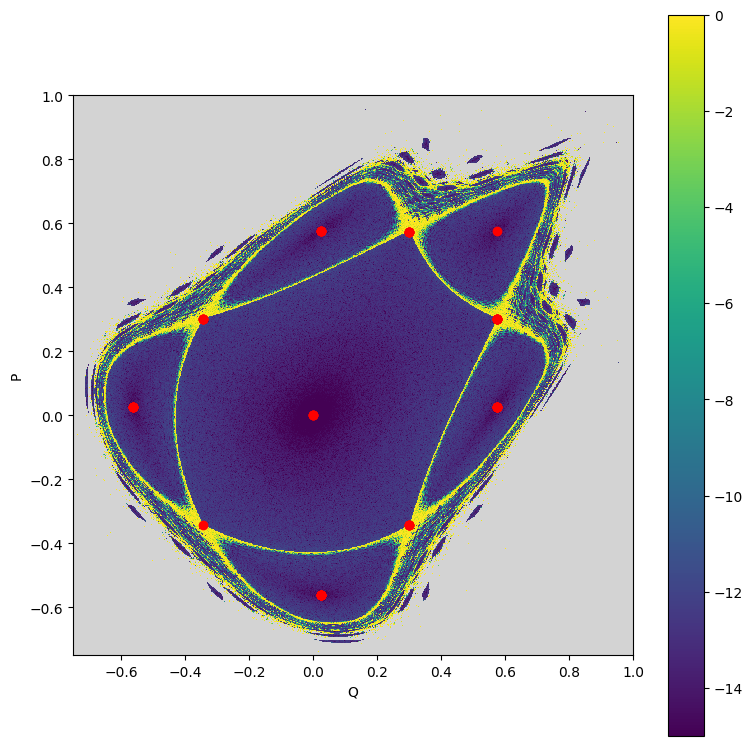

In [11]:
# Note, after removing nan values, we can still have values that are not actually a fixed point
# Additionaly, values corresponding to a smaller period can present
# And multiple identical values from different guess points converged to the same result

plt.figure(figsize=(8, 8))
plt.scatter(*points.T, color='red')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

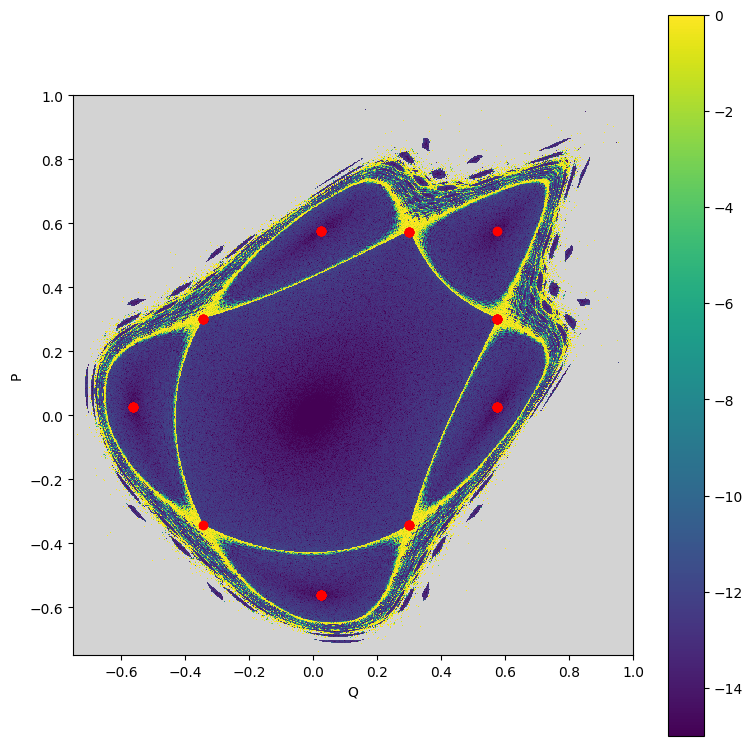

In [12]:
# Keep only prime fixed points

mask = jit(vmap(prime(forward2D, order=order, rtol=1.0E-9, atol=1.0E-9), (0, None)))(points, k)
points = points[mask]

plt.figure(figsize=(8, 8))
plt.scatter(*points.T, color='red')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

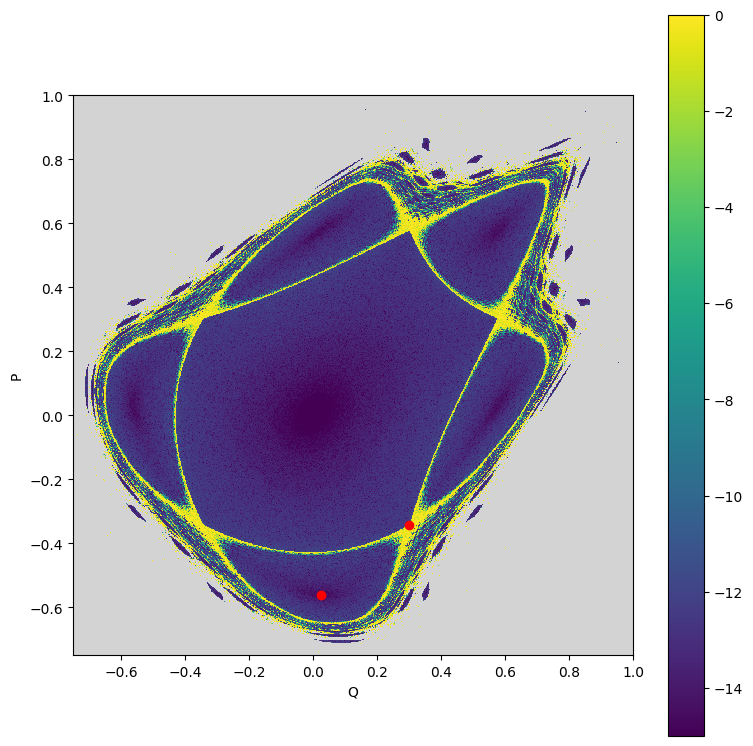

In [13]:
# Next step is to keep only unique chains

mask = unique(order, forward2D, points, k, tol=1.0E-9)
points = points[mask]

plt.figure(figsize=(8, 8))
plt.scatter(*points.T, color='red')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

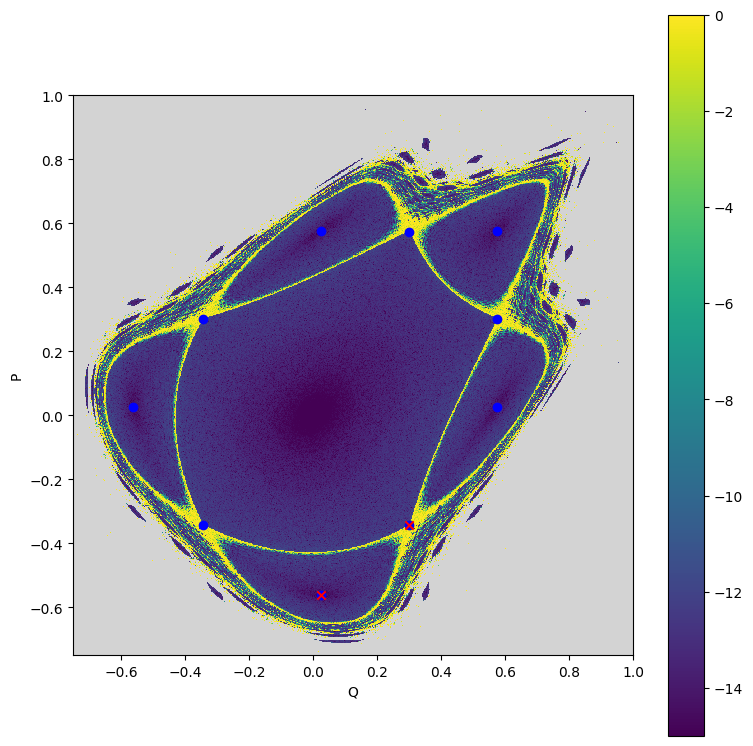

In [14]:
# Generate full chains (starting point is not included)

chains = jax.numpy.vstack(jit(vmap(chain(order, forward2D), (0, None)))(points, k))

plt.figure(figsize=(8, 8))
plt.scatter(*chains.T, color='blue')
plt.scatter(*points.T, color='red', marker='x')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

In [15]:
# Fixed point type can be infered from monodromy eigenvalues

# For each fixed point, corresponding monodromy matrix is computed
# Next, eigenvalues and eigenvectors are computed and combined into pairs
# For each pair of eigenvalues, classification if performed, for example:

# [True] -- E
# [False] -- H
# [True, True] -- EE
# [True, False] -- EH

pe, ph = points
me, mh = jit(vmap(monodromy(order, forward2D), (0, None)))(points, k)

# EP

es, vs = jax.numpy.linalg.eig(me)
es, vs = combine(es, vs)
print(classify(es))

# HP

es, vs = jax.numpy.linalg.eig(mh)
es, vs = combine(es, vs)
print(classify(es))

[ True]
[False]


In [16]:
# HP manifolds classification

# If eigenvalue > 1, the corresponding manifold (eigenvector) is unstable (False)
# If eigenvalue < 1, the corresponding manifold (eigenvector) is stable   (True)

print(manifold(es.flatten()))
print()

# Set vectors

(wu, ws), *_ = vs.real

# For unstable (stable) manifold one should use forward (inverse) transformation

forward = nest(order, forward2D)
inverse = nest(order, inverse2D)

# Given a point on an unstable manifold
# Application of forward mapping moves the point away from the HP
# While application of unstable mapping moves the point closer to the HP
# To construct the manifold, one needs to use forward mapping

epsilon = 1.0E-9

point = ph + wu*epsilon
print(jax.numpy.linalg.norm(forward(point, k) - ph) > jax.numpy.linalg.norm(point - ph))
print(jax.numpy.linalg.norm(inverse(point, k) - ph) < jax.numpy.linalg.norm(point - ph))
print()

# Similar for the opposite direction

point = ph - wu*epsilon
print(jax.numpy.linalg.norm(forward(point, k) - ph) > jax.numpy.linalg.norm(point - ph))
print(jax.numpy.linalg.norm(inverse(point, k) - ph) < jax.numpy.linalg.norm(point - ph))
print()

# Given the point on a stable manifold the logic should be reversed
# To construct the manifold, one needs to use inverse mapping

epsilon = 1.0E-9

point = ph + ws*epsilon
print(jax.numpy.linalg.norm(forward(point, k) - ph) < jax.numpy.linalg.norm(point - ph))
print(jax.numpy.linalg.norm(inverse(point, k) - ph) > jax.numpy.linalg.norm(point - ph))
print()

point = ph - ws*epsilon
print(jax.numpy.linalg.norm(forward(point, k) - ph) < jax.numpy.linalg.norm(point - ph))
print(jax.numpy.linalg.norm(inverse(point, k) - ph) > jax.numpy.linalg.norm(point - ph))
print()

[False  True]

True
True

True
True

True
True

True
True



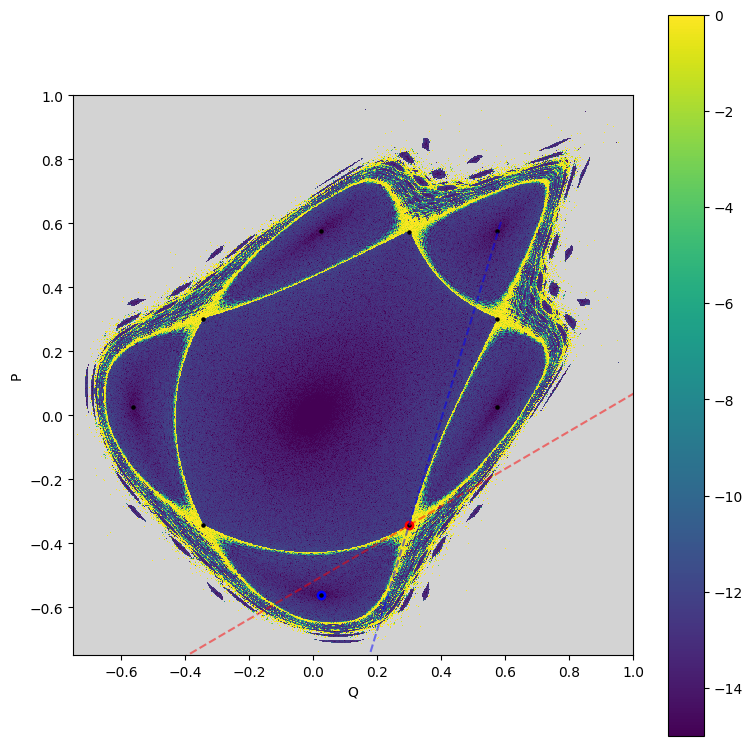

In [17]:
# HP manifolds (directions)

# wu -- forward
# ws -- inverse

ls = ph + ws.real*jax.numpy.linspace(-1.0, 1.0, 10).reshape(-1, 1)
lu = ph + wu.real*jax.numpy.linspace(-1.0, 1.0, 10).reshape(-1, 1)

plt.figure(figsize=(8, 8))
plt.plot(*ls.T, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(*lu.T, color='red', linestyle='dashed', alpha=0.5)
plt.scatter(*pe, color='blue')
plt.scatter(*ph, color='red')
plt.scatter(*chains.T, color='black', s=5)
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

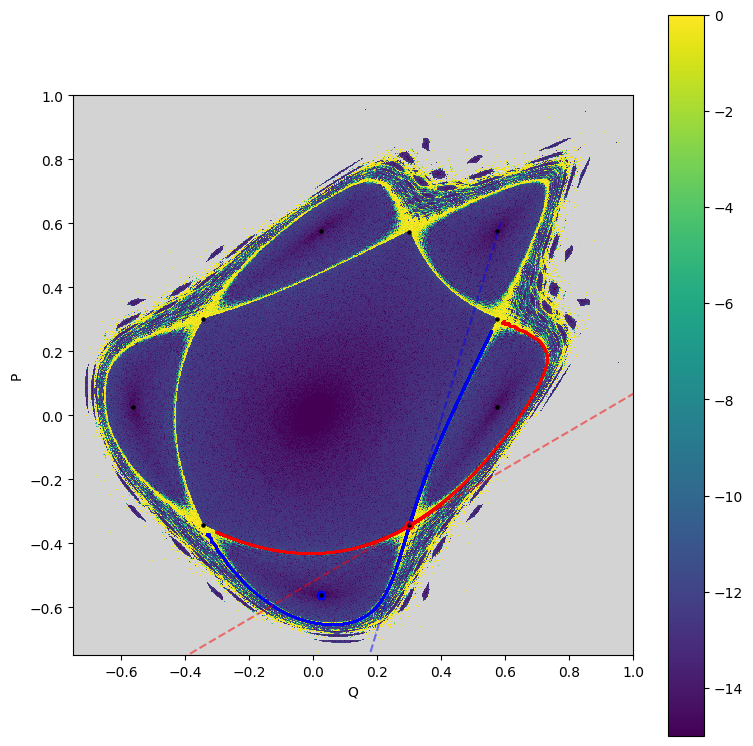

In [18]:
# HP manifolds (construction)

# wu -- forward
# ws -- inverse

epsilon = 1.0E-9

xu = ph + wu.real*jax.numpy.linspace(-epsilon, epsilon, 4096).reshape(-1, 1)
xs = ph + ws.real*jax.numpy.linspace(-epsilon, epsilon, 4096).reshape(-1, 1)

mu = vmap(jit(nest_list(50, forward)), (0, None))(xu, k).reshape(-1, 2)
ms = vmap(jit(nest_list(50, inverse)), (0, None))(xs, k).reshape(-1, 2)

plt.figure(figsize=(8, 8))
plt.scatter(*ms.T, color='blue', alpha=0.25, s=0.1)
plt.scatter(*mu.T, color='red', alpha=0.25, s=0.1)
plt.plot(*ls.T, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(*lu.T, color='red', linestyle='dashed', alpha=0.5)
plt.scatter(*pe, color='blue')
plt.scatter(*ph, color='red')
plt.scatter(*chains.T, color='black', s=5)
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()